In [1]:
# Geography 136 - EnvDataSci 
# Ethan Kadiyala

# Examining Air Quality Trends During Stay at Home Orders

In [2]:
## Imports
import numpy as np                  # import nummpy
import pandas as pd                 # import pandas
from scipy import stats             # import scipy stats for t-tests and linear regression
import matplotlib.pyplot as plt     # import matplotlib
import matplotlib.dates as mdates
import geopandas as gpd             # import geopandas for spatial analysis
import geoplot                      # import geoplot to plot the spatial data
import contextily as ctx            # import contextily to add basemaps to plots

In [3]:
# import csv's, each csv contains data from a specific study region for the months of March and April
# set variables for each csv
bay_base= pd.read_csv('air_data/17_18_19_OZONE_BAY.csv')
la_base= pd.read_csv('air_data/17_18_19_OZONE_LA.csv')
la_2020= pd.read_csv('air_data/2020_OZONE_LA.csv')
bay_2020= pd.read_csv('air_data/2020_OZONE_BAY.csv')

#### Data from the EPA website, ozone has the most complete data, both spatially in the number of stations and temporally in the number of records. Ozone is also a good metric to study air pollution from car exausts, AQI considers too many factors.

In [4]:
bay_base.head(n = 3)
# la_base.head()
# bay_2020.head()
# la_2020.head()
# bay_base.columns

,DATE,ID,DAY_MAX_OZONE,DAILY_AQI_VALUE,SITE_NAME,DAILY_OBS_COUNT,PERCENT_COMPLETE,CBSA_CODE,CBSA_NAME,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,2017-03-01 0:00:00,60010007,0.037,34,Livermore,17,100,41860,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217
1,2017-03-02 0:00:00,60010007,0.038,35,Livermore,17,100,41860,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217
2,2017-03-03 0:00:00,60010007,0.036,33,Livermore,17,100,41860,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217


## Los Angeles Stations

In [5]:
# set simple variables for the dfs, LA first
df_old = la_base    # baseline from 2017-2019

df_new = la_2020    # 2020 data

In [6]:
# set the index as the site ID
df_old_ID = df_old.set_index(['ID'])

df_new_ID = df_new.set_index(['ID'])

In [7]:
# make sure the dfs contain the same sites, some sites from the baseline were decommissioned before 2020 
df_old_ID_match = df_old_ID.loc[df_new_ID.index.unique()]

In [8]:
print(df_old_ID_match.index.unique())

Int64Index([60370002, 60370016, 60370113, 60371103, 60371201, 60371302,
            60371602, 60371701, 60372005, 60375005, 60376012, 60379033,
            60590007, 60592022, 60595001, 60650012, 60650016, 60656001,
            60658001, 60658005, 60659001, 60710005, 60710012, 60710306,
            60711004, 60712002, 60714001, 60714003, 60719004, 60731008,
            61110007, 61110009, 61112002, 61113001],
           dtype='int64', name='ID')


In [9]:
print(df_new_ID.index.unique())

Int64Index([60370002, 60370016, 60370113, 60371103, 60371201, 60371302,
            60371602, 60371701, 60372005, 60375005, 60376012, 60379033,
            60590007, 60592022, 60595001, 60650012, 60650016, 60656001,
            60658001, 60658005, 60659001, 60710005, 60710012, 60710306,
            60711004, 60712002, 60714001, 60714003, 60719004, 60731008,
            61110007, 61110009, 61112002, 61113001],
           dtype='int64', name='ID')


In [10]:
# reset index
df_old = df_old_ID_match.reset_index()

df_new = df_new_ID.reset_index()

# convert DATE to datetime objects
df_old['DATE'] = pd.to_datetime(df_old['DATE'])
df_new['DATE'] = pd.to_datetime(df_new['DATE'])

In [11]:
# set index to DATE
df_old_date = df_old.set_index('DATE')

df_new_date = df_new.set_index('DATE')
df_old_date.head(n=3)

,ID,DAY_MAX_OZONE,DAILY_AQI_VALUE,SITE_NAME,DAILY_OBS_COUNT,PERCENT_COMPLETE,CBSA_CODE,CBSA_NAME,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
DATE,,,,,,,,,,,
2017-03-01,60370002,0.046,43,Azusa,17,100,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,34.1365,-117.92391
2017-03-03,60370002,0.042,39,Azusa,17,100,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,34.1365,-117.92391
2017-03-04,60370002,0.051,47,Azusa,17,100,31080,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,34.1365,-117.92391


#### At this point we have a baseline df with three years of data from March and April and 2020 df with 61 days of data from the same two months.

#### Next we will fill any missing records in the 2020 df with nans. This is important for conducting paired t-tests, as both samples need to be the same length.

In [12]:
# make an empty list 
df_list = []

# design a for loop that uses masking to iterate through the IDs, and reindexing to include all days in the month of march and april
for ID in df_new_date['ID'].unique():
    # mask by ID
    x = df_new_date[df_new_date.ID == ID]
    
    # set range for index
    idx = pd.date_range(min(df_new_date.index), max(df_new_date.index))
   
    # reindex the df to have 61 days
    y = x.reindex(idx)
    # make sure that the ID column is complete, no NaNs
    y['ID'] = ID
    
    # append to the newly created list
    df_list.append(y)
    
# concatenate the new list     
df_2020 = pd.concat(df_list)

df_2020.head(n = 3)

,ID,DAY_MAX_OZONE,DAILY_AQI_VALUE,SITE_NAME,DAILY_OBS_COUNT,PERCENT_COMPLETE,CBSA_CODE,CBSA_NAME,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
2020-03-01,60370002,0.044,41.0,Azusa,24.0,100.0,31080.0,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,34.1365,-117.92391
2020-03-02,60370002,0.042,39.0,Azusa,24.0,100.0,31080.0,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,34.1365,-117.92391
2020-03-03,60370002,0.042,39.0,Azusa,24.0,100.0,31080.0,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,34.1365,-117.92391


#### Average the baseline data by day, to match the 61 days in the 2020 df

In [13]:
# group baseline by site, then month, then day
baseline =  df_old_date.groupby([df_old_date.ID, df_old_date.index.month, df_old_date.index.day]).mean()

# convert to a df
df_base = pd.DataFrame(baseline)

# reset the index one level at a time
df_base_1 = df_base.reset_index(level = 0)
df_base_2 = df_base_1.reset_index(level = 0)

# rename DATE to MONTH to avoid duplicate column names
df_base_2['MONTH'] = df_base_2['DATE']
# delete the DATE column
del df_base_2['DATE']

# reset the last index
df_base_3 = df_base_2.reset_index()

# rename DATE to Day
df_base_3['DAY'] = df_base_3['DATE']
# delete the DATE column
del df_base_3['DATE']

# simplify variable name
df_base = df_base_3
df_base.head()
# a three year baseline of ozone data, contains daily data for 34 monitoring stations over 61 days each, totaling 2074  

,ID,DAY_MAX_OZONE,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,CBSA_CODE,SITE_LATITUDE,SITE_LONGITUDE,MONTH,DAY
0,60370002,0.039333,36.666667,17.0,100.0,31080.0,34.1365,-117.92391,3,1
1,60370002,0.030000,28.000000,17.0,100.0,31080.0,34.1365,-117.92391,3,2
2,60370002,0.042000,39.000000,17.0,100.0,31080.0,34.1365,-117.92391,3,3
3,60370002,0.042000,39.000000,17.0,100.0,31080.0,34.1365,-117.92391,3,4
4,60370002,0.042000,39.000000,17.0,100.0,31080.0,34.1365,-117.92391,3,5


#### Visualize the data in a bar graph, averaging the data by site over the 61 days

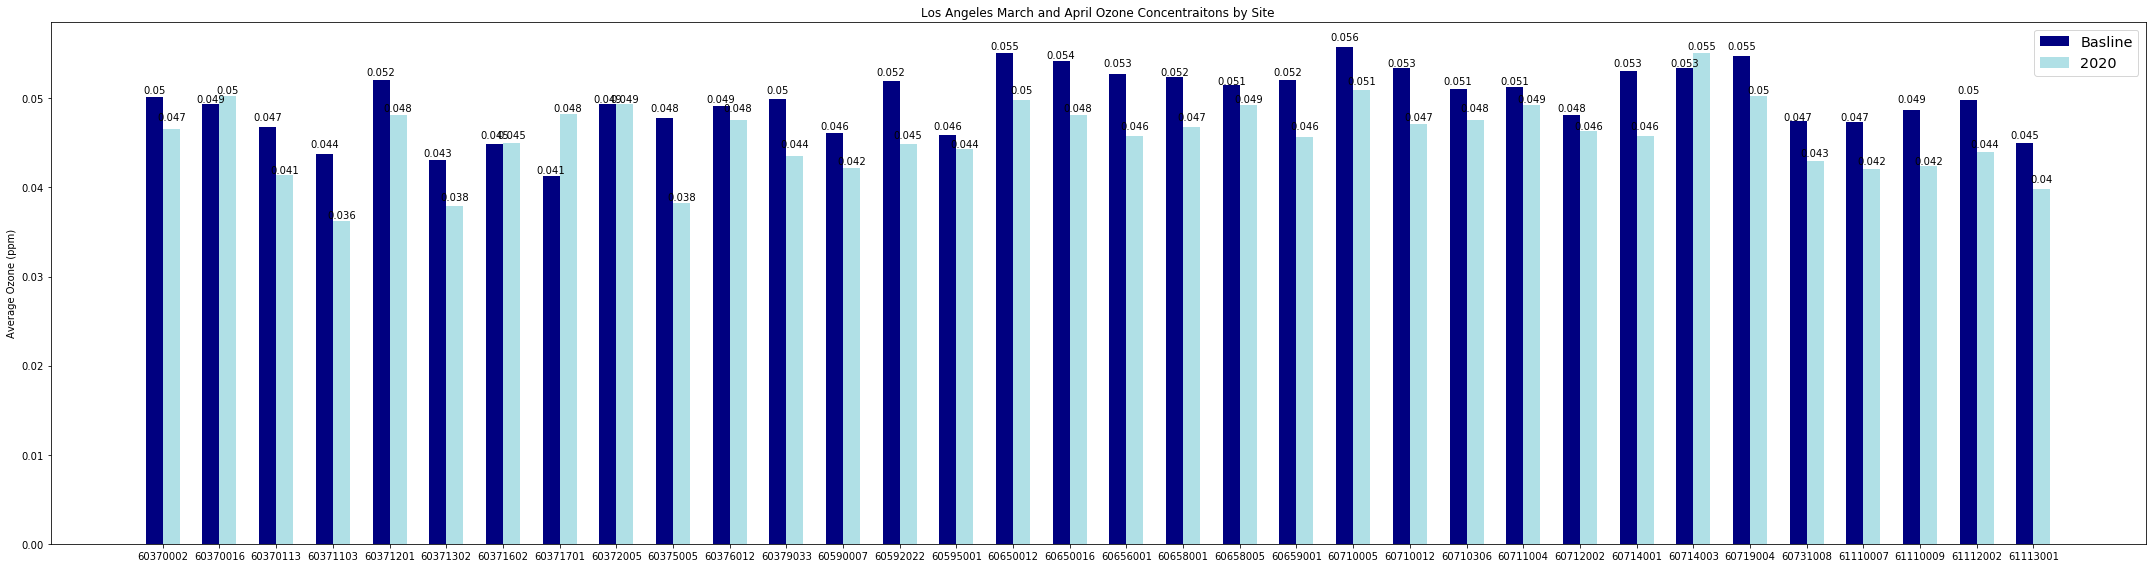

In [14]:
# calculate site by site averages for the baseline data and 2020

# Base
# Group by ID and take the mean for each station
ID_base = df_base.groupby('ID').mean()

# 2020
# Group by ID and take the mean for each station
ID_2020 = df_2020.groupby('ID').mean()

# add the ozone values as a list


# plot data

# make a list of each ID
labels = []
for ID in ID_base.index.unique():
    labels.append(ID)


x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

# initialize figure and axis
fig = plt.figure(figsize = (30,8))
ax = fig.add_subplot()

# set up bars, one for the baseline and one for 2020
rects1 = ax.bar(x*2 - width/2, ID_base.DAY_MAX_OZONE, width, label='Basline', color = 'navy')
rects2 = ax.bar(x*2 + width/2, ID_2020.DAY_MAX_OZONE, width, label='2020', color = 'powderblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Ozone (ppm)')
ax.set_title('Los Angeles March and April Ozone Concentraitons by Site')
ax.set_xticks(x*2)
ax.set_xticklabels(labels)
ax.legend(fontsize = 'x-large')

# autolabel function taken from matplotlib
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [15]:
# conduct t-test on all sites
for ID in df_base.ID.unique():
    x = df_base.DAY_MAX_OZONE[df_base.ID == ID]
    y = df_2020.DAY_MAX_OZONE[df_2020.ID == ID]
    test = stats.ttest_rel(x, y, nan_policy = 'omit')
#     print(test, 'Station:', ID)
    if test.pvalue <= .05:
        print('Station:', ID, 'is significant' )

Station: 60370002 is significant
Station: 60370113 is significant
Station: 60371103 is significant
Station: 60371201 is significant
Station: 60371302 is significant
Station: 60371701 is significant
Station: 60375005 is significant
Station: 60379033 is significant
Station: 60590007 is significant
Station: 60592022 is significant
Station: 60650012 is significant
Station: 60650016 is significant
Station: 60656001 is significant
Station: 60658001 is significant
Station: 60659001 is significant
Station: 60710005 is significant
Station: 60710012 is significant
Station: 60710306 is significant
Station: 60714001 is significant
Station: 60719004 is significant
Station: 60731008 is significant
Station: 61110007 is significant
Station: 61110009 is significant
Station: 61112002 is significant
Station: 61113001 is significant


#### 25 out of the 34 stations expereinced a significant change in Ozone concentration

## Bay Area Stations

#### Same drill, but for the Bay Area

In [16]:
# set simple variables for the Bay dfs
df_old = bay_base    # baseline from 2017-2019

df_new = bay_2020    # 2020 data

In [17]:
# set the index as the site ID
df_old_ID = df_old.set_index(['ID'])

df_new_ID = df_new.set_index(['ID'])


In [18]:
# make sure the dfs contain the same sites
df_old_ID_match = df_old_ID.loc[df_new_ID.index.unique()]

In [19]:
# reset index
df_old = df_old_ID_match.reset_index()

df_new = df_new_ID.reset_index()

# convert DATE to datetime objects
df_old['DATE'] = pd.to_datetime(df_old['DATE'])
df_new['DATE'] = pd.to_datetime(df_new['DATE'])

In [20]:
# set index to DATE
df_old_date = df_old.set_index('DATE')

df_new_date = df_new.set_index('DATE')

In [21]:
# make an empty list 
df_list = []

# design a for loop that uses masking to iterate through the IDs, and reindexing to include all days in the month of march and april
for ID in df_new_date['ID'].unique():
    # mask by ID
    x = df_new_date[df_new_date.ID == ID]
    # set range for index
    idx = pd.date_range(min(df_new_date.index), max(df_new_date.index))
    # reindex the df to have 61 days
    y = x.reindex(idx)
    # make sure that the ID column is complete, no NaNs
    y['ID'] = ID
    # append to the newly created list
    df_list.append(y)
    
# concatenate the new list     
df_2020 = pd.concat(df_list)

In [22]:
# group baseline by site, then month, then day
baseline =  df_old_date.groupby([df_old_date.ID, df_old_date.index.month, df_old_date.index.day])['DAY_MAX_OZONE'].mean()
baseline
# convert to a df
df_base = pd.DataFrame(baseline)

# reset the index one level at a time
df_base_1 = df_base.reset_index(level = 0)
df_base_2 = df_base_1.reset_index(level = 0)

# rename DATE to DAY to avoid duplicate column names
df_base_2['DAY'] = df_base_2['DATE']
# delete the DATE column
del df_base_2['DATE']

# reset the last index
df_base_3 = df_base_2.reset_index()

# rename DATE to MONTH
df_base_3['MONTH'] = df_base_3['DATE']
# delete the DATE column
del df_base_3['DATE']

# simplify variable name
df_base = df_base_3
 

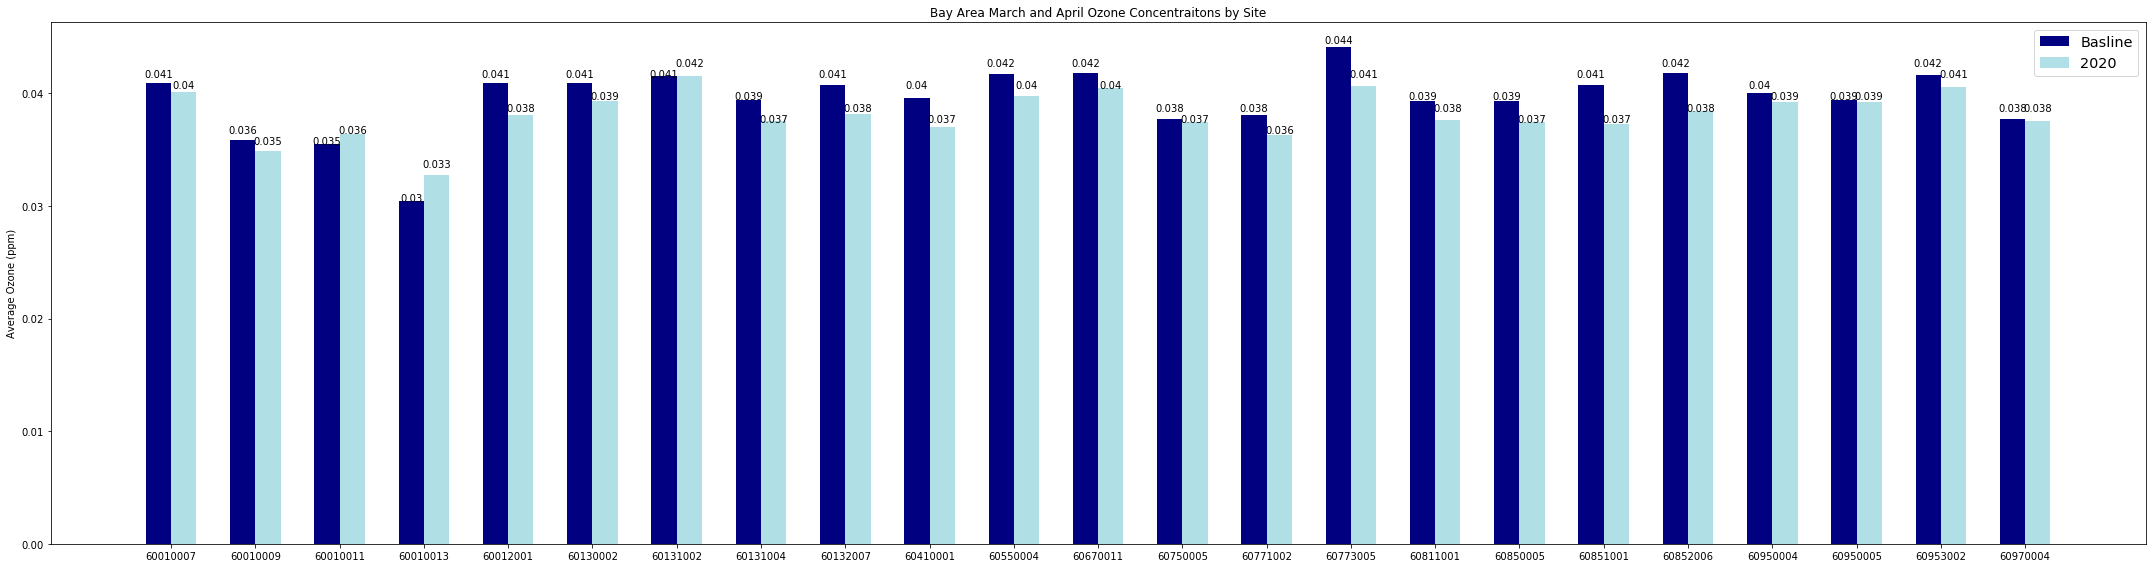

In [23]:
# calculate site by site averages for the baseline data and 2020

# Base
# Group by ID and take the mean for each station
ID_base = df_base.groupby('ID').mean()

# 2020
# Group by ID and take the mean for each station
ID_2020 = df_2020.groupby('ID').mean()

# add the ozone values as a list


# plot data

# make a list of each ID
labels = []
for ID in ID_base.index.unique():
    labels.append(ID)


x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig = plt.figure(figsize = (30,8))
ax = fig.add_subplot()
rects1 = ax.bar(x*2 - width/2, ID_base.DAY_MAX_OZONE, width, label='Basline', color = 'navy')
rects2 = ax.bar(x*2 + width/2, ID_2020.DAY_MAX_OZONE, width, label='2020', color = 'powderblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Ozone (ppm)')
ax.set_title('Bay Area March and April Ozone Concentraitons by Site')
ax.set_xticks(x*2)
ax.set_xticklabels(labels)
ax.legend(fontsize = 'x-large')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(), 3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [24]:
# conduct t-test on all sites
for ID in df_base.ID.unique():
    x = df_base.DAY_MAX_OZONE[df_base.ID == ID]
    y = df_2020.DAY_MAX_OZONE[df_2020.ID == ID]
    if len(x) == 61:    
        t_stat, p_val = stats.ttest_rel(x, y, nan_policy = 'omit')
        if test.pvalue <= .05:
            print('Station:', ID, 'is significant' )
    else:
        print(ID, 'is not equal length') # caused by how my method of reindexing, could be fixed

Station: 60010007 is significant
Station: 60010009 is significant
Station: 60010011 is significant
Station: 60010013 is significant
Station: 60012001 is significant
Station: 60130002 is significant
Station: 60131002 is significant
Station: 60131004 is significant
Station: 60132007 is significant
Station: 60410001 is significant
Station: 60550004 is significant
Station: 60670011 is significant
Station: 60750005 is significant
Station: 60771002 is significant
Station: 60773005 is significant
Station: 60811001 is significant
Station: 60850005 is significant
Station: 60851001 is significant
Station: 60852006 is significant
Station: 60950004 is significant
Station: 60950005 is significant
60953002 is not equal length
Station: 60970004 is significant


#### 22 out of 23 stations experienced a significant change in Ozone concentration

## Spatial Analysis of Los Angeles Metropolitan Area

#### Goal: to use spatial data to comapre income inequality to air pollution using the basline data and median household income data

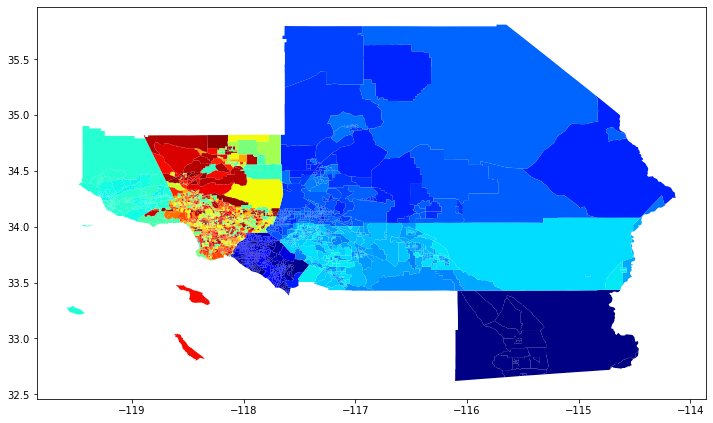

In [25]:
# read shapefiles
# import median income data for la metro area
metro = gpd.read_file('air_data/income.shp')
metro.plot(cmap = 'jet' , column = 'OBJECTID' , figsize = (12,10))

In [26]:
# import the same air quality data from earlier, converted to shapefiles, this could be done using the gpd.GeoDataFrame() function
base = gpd.read_file('air_data/la_base_points.shp')

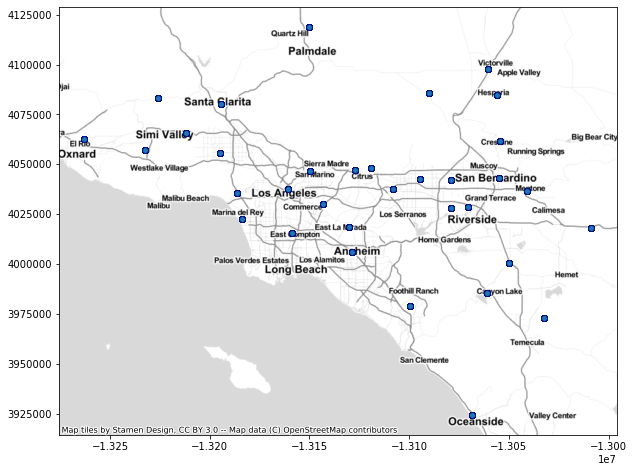

In [27]:
#convert to mercator for plotting purposes
base_merc = base.to_crs(epsg=3857)
# plot
ax = base_merc.plot(figsize=(10, 10), alpha=0.5, edgecolor='navy')
# add a basemap
ctx.add_basemap(ax, zoom= 9, source=ctx.providers.Stamen.TonerLite)

#### Now that we've plotted each shapefile, let's see how they're organized:

In [28]:
metro.head(n=3)

,OBJECTID,GEOID10,COUNTYFP10,TRACTCE10,Cnty_Name,City_Name,ZIP,Acres,SqMi,Pop_16,...,UnEmp_Rate,Emp_15,Emp_Den,Emp_Src,Income_Pct,Income_Rpt,Income_Src,Under19_Pc,MHI2016,geometry
0,1,06025011802,025,011802,Imperial,El Centro,92243,423.847547,0.662262,5582,...,0.102075,1475,2227.215911,LEHD 2015,43913,2011-2015,ACS_15_5YR_DP03,31.5,43833,"POLYGON ((-115.56966 32.78144, -115.56964 32.7..."
1,2,06025011700,025,011700,Imperial,El Centro,92243,484.274076,0.756678,5469,...,0.153078,2285,3019.777586,LEHD 2015,47000,2011-2015,ACS_15_5YR_DP03,28.6,47670,"POLYGON ((-115.56966 32.78144, -115.56966 32.7..."
2,3,06025011600,025,011600,Imperial,El Centro,92243,505.805470,0.790321,6021,...,0.330330,2247,2843.148374,LEHD 2015,23982,2011-2015,ACS_15_5YR_DP03,27.8,29135,"POLYGON ((-115.56966 32.78150, -115.56966 32.7..."


In [29]:
base.head(n=3)

,Field1,ID,DAY_MAX_OZ,DAILY_AQI_,DAILY_OBS_,PERCENT_CO,CBSA_CODE,SITE_LATIT,SITE_LONGI,MONTH,DAY,geometry
0,0,60370002,0.039333,36.666667,17.0,100.0,31080.0,34.1365,-117.92391,3,1,POINT Z (-117.92391 34.13650 0.00000)
1,1,60370002,0.030000,28.000000,17.0,100.0,31080.0,34.1365,-117.92391,3,2,POINT Z (-117.92391 34.13650 0.00000)
2,2,60370002,0.042000,39.000000,17.0,100.0,31080.0,34.1365,-117.92391,3,3,POINT Z (-117.92391 34.13650 0.00000)


#### The geometry coloumn is the main component that distinguishes a gdf from a df.


#### Now let's average the point data by station:

In [30]:
# take the mean of each station
df = base.groupby('ID').mean()       # output is a df

# convert back to a geodataframe
av_base = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.SITE_LONGI, df.SITE_LATIT))      # one way to convert a df to a gdf

# set crs to match the metro shapefile
av_base.crs = 'epsg:4326'

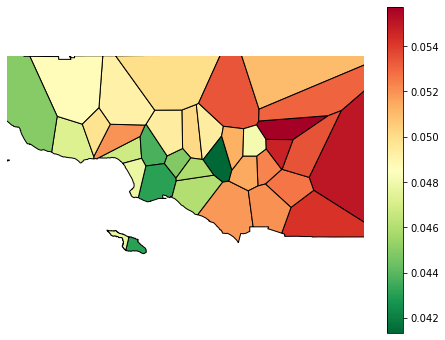

In [31]:
# best try at interpolating the ozone data, creates thiessen polygons centered around our stations
geoplot.voronoi(av_base, hue = 'DAY_MAX_OZ', legend = 'true', cmap = 'RdYlGn_r', clip = metro)     # The '_r' in RdYlGn_r reverses the color ramp

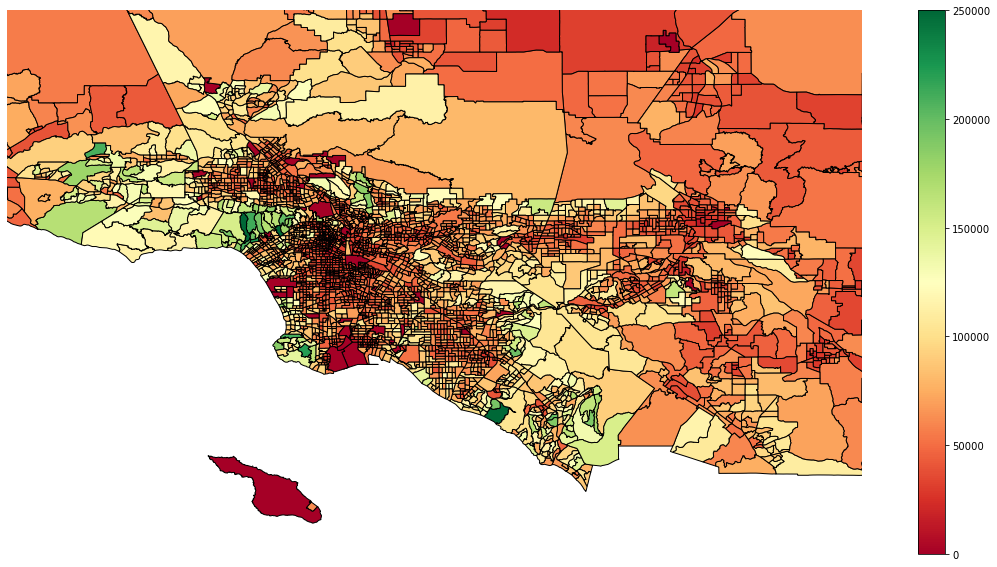

In [32]:
# make a chloropleth map representing median income on a ryg color ramp
geoplot.choropleth(metro, hue='MHI2016', cmap='RdYlGn', legend= 'true', figsize=(20, 10), extent = (base.SITE_LONGI.min(), base.SITE_LATIT.min(), base.SITE_LONGI.max(), base.SITE_LATIT.max()))

#### In order to find the income data for our air quality stations, we can overlay the data:

In [33]:
# overlay data
base_overlay = gpd.overlay(av_base, metro, how = 'intersection')   # intersect to maintain point format
base_overlay.head(n =3 )

,Field1,DAY_MAX_OZ,DAILY_AQI_,DAILY_OBS_,PERCENT_CO,CBSA_CODE,SITE_LATIT,SITE_LONGI,MONTH,DAY,...,UnEmp_Rate,Emp_15,Emp_Den,Emp_Src,Income_Pct,Income_Rpt,Income_Src,Under19_Pc,MHI2016,geometry
0,30.0,0.050126,52.155738,16.978142,99.868852,31080.0,34.13650,-117.92391,3.491803,15.754098,...,0.054417,2934,856.485407,LEHD 2015,74219,2011-2015,ACS_15_5YR_DP03,26.0,74038,POINT (-117.92391 34.13650)
1,91.0,0.049363,50.901639,17.060109,99.672131,31080.0,34.14435,-117.85036,3.491803,15.754098,...,0.059888,181,323.535396,LEHD 2015,91607,2011-2015,ACS_15_5YR_DP03,27.0,104688,POINT (-117.85036 34.14435)
2,152.0,0.046760,45.475410,16.841530,99.049180,31080.0,34.05111,-118.45636,3.491803,15.754098,...,0.234899,5664,5798.868169,LEHD 2015,0,None,None,3.2,44531,POINT (-118.45636 34.05111)


#### Visualize the intersected data:

In [34]:
# add really small buffers to turn points into polygons, required for cartograms
base_polygon = base_overlay.buffer(distance = .1)

# output is a geo series, convert to geo df
base_poly = gpd.GeoDataFrame(geometry = base_polygon)     # Another way to make a gdf

# set crs to match the metro shapefile
base_poly.crs = 'epsg:4326'

# add ozone data and income data to polygon features
base_poly['OZONE'] = base_overlay.DAY_MAX_OZ
base_poly['MHI'] = base_overlay.MHI2016


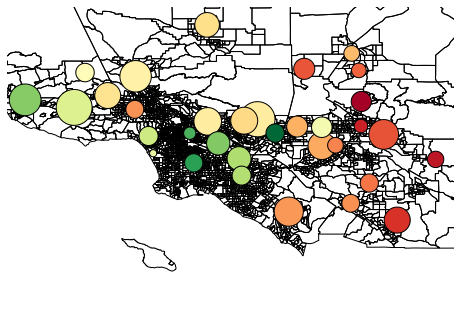

In [35]:
# plot a cartogram with Median Income as scale and Ozone as color
ax = geoplot.cartogram(base_poly, scale = 'MHI', hue = 'OZONE', cmap = 'RdYlGn_r')

# add the cartogram plot to a polyplot, allowing us to add the metro shapefile to the plot
geoplot.polyplot(metro, ax=ax, extent = (base.SITE_LONGI.min() - .1, base.SITE_LATIT.min() - .1, base.SITE_LONGI.max() + .1, base.SITE_LATIT.max() + .1))

#### Plot the data and run a regression to see if there's a correlation:

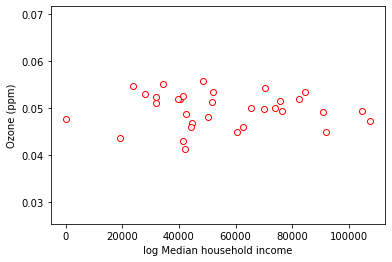

In [36]:
# set a simple name for my gdf
df = base_poly

# plot ozone and MHI on a scatter plot
plt.scatter(df.MHI, df.OZONE, edgecolors = 'r', color = 'w')
plt.xlabel("log Median household income")
plt.ylabel("Ozone (ppm)")
plt.show()

In [37]:
# run a linear regression test
stats.linregress(df.MHI, df.OZONE)

LinregressResult(slope=-6.07179316019612e-09, intercept=0.05006264767855388, rvalue=-0.041566808203817904, pvalue=0.8183442107155678, stderr=2.6212831314115356e-08)

##### The regression test returned a really small R squared value, indicating that there's not a linear correlation between income and ozone. This result could be improved with a larger sample size and possibly different metrics for air pollution and income.

##### Learn more about this project at: https://drive.google.com/file/d/18eZWGMYiuHsHW6coPmZtBbOiHYaFIQNR/view?usp=sharing